<a href="https://colab.research.google.com/github/KunalVaidya99/Image-Colorization-Using-Deep-Learning/blob/main/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [16]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import (Conv2D,Conv2DTranspose,UpSampling2D,MaxPooling2D,Input
                          ,Activation,Concatenate,BatchNormalization,Flatten,Reshape
                          ,Dense,RepeatVector)
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.models import Model
import numpy as np
from keras.preprocessing.image import load_img
from PIL import Image
from skimage.color import gray2rgb
import os
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [42]:
class DataGenerator(keras.utils.Sequence):
 
  def __init__(self,directory,filenames,batch_size=32,dim=(256,256),n_channels=3,shuffle=True):
    
    self.dim=dim
    self.filenames=filenames
    self.batch_size=batch_size
    self.n_channels=n_channels
    self.shuffle=shuffle
    self.directory=directory
    self.on_epoch_end()
    
 
  def __len__(self):
    return int(np.floor(len(self.filenames)/self.batch_size))
 
  def __getitem__(self,index):
    
    batch_files = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
 
    
 
    X,Y,resized,gray = self.__data_generation(batch_files)
 
    return X,Y,resized,gray
 
  def on_epoch_end(self):
    if self.shuffle == True :
      np.random.shuffle(self.filenames)
 
  def __data_generation(self,batch_files):
 
    X = np.empty((self.batch_size,*self.dim,1))
    Y = np.empty((self.batch_size,*self.dim,self.n_channels))
    resized  = np.empty((self.batch_size,224,224,3))
    gray = np.empty((self.batch_size,224,224,3))
    count =0 
    
 
    for files in batch_files:
 
     
      image = Image.open(self.directory + "/" + files)
 
      if (np.array(image).shape==(256,256,3)) :
 
        g_image = image

        img = image.resize((224,224))
        resized[count] = np.array(img)/255
        g = np.array(img.convert("L"))
        gray[count] = gray2rgb(g)/255

 
        Y[count,] = (np.array(image))/255
 
        X[count,] = (np.expand_dims(np.array(g_image.convert("L")),axis=-1))/255
 
        count = count + 1
 
    return X,Y,resized,gray

In [43]:
directory = "/content/gdrive/My Drive/val_256"
filenames = os.listdir(directory)
random.shuffle(filenames)
split_size = 0.1
train_files = filenames[int(split_size*len(filenames)):len(filenames)]
test_files = filenames[:int(split_size*len(filenames))]
TrainGenerator = DataGenerator(directory,train_files)
TestGenerator = DataGenerator(directory,test_files)
img_shape = (256,256,1)

In [ ]:
X,Y = TrainGenerator.__getitem__(3)

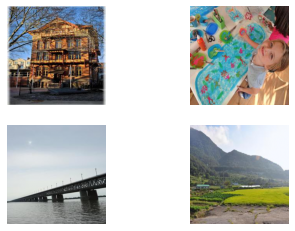

In [ ]:
def show_images(n_rows,n_cols):
 
  fig,axs = plt.subplots(nrows=n_rows,ncols=n_cols)
  count = 0
  for i in range(n_rows):
    for j in range(n_cols):
      axs[i,j].imshow(Y[count,:,:])
      axs[i,j].axis('off')
      count = count + 1
 
show_images(2,2)

In [11]:
def downsample_block(layer_input,filters):

  X = Conv2D(filters,kernel_size=(3,3),padding='same')(layer_input)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters,kernel_size=(3,3),padding='same')(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((2,2))(X)

  return X

In [12]:
def upsample_block(layer_input,skip_input,filters,concat=True):

  #X = UpSampling2D((2,2))(layer_input)
  if(concat==True):
    X = Concatenate(axis=-1)([layer_input,skip_input])
  else:
    X = layer_input  

  X = Conv2D(filters[0],kernel_size=(3,3),padding='same')(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters[1],kernel_size=(3,3),padding='same')(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2DTranspose(filters=filters[1],kernel_size=(3,3),strides=(2,2),padding='same')(X)

  return X

In [13]:
def UNet_generator(img_shape):

  input_img = Input(shape=img_shape)

  d1 = downsample_block(input_img,filters=64)
  
  d2 = downsample_block(d1,filters=128) 
 
  d3 = downsample_block(d2,filters=256)
 
  d4 = downsample_block(d3,filters = 512)
  
  #print(d4_pool.shape)

  #u1 = upsample_block(d,NULL,filters=[1024,512],concat=False)
  u1 = upsample_block(d4,None,filters=[512,256],concat=False)
  #print(u1.shape)
  u2 = upsample_block(u1,d3,filters=[256,128])
  u3 = upsample_block(u2,d2,filters=[128,64])
  u4 = upsample_block(u3,d1,filters=[64,32])

  out = Conv2D(3,kernel_size=(1,1),padding='same')(u4)
  out = BatchNormalization(axis=-1)(out)
  #out = Activation("sigmoid")(out)

  model = Model(inputs=input_img,outputs=out)

  return model

In [15]:
unet = UNet_generator(img_shape)
opt = Adam(learning_rate=0.001)
unet.load_weights("/content/gdrive/My Drive/ImageColorization /Model5.h5")
unet.compile(optimizer=opt,loss="mean_squared_error")
r_plateau = keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.2,patience=2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
unet.fit_generator(TrainGenerator,validation_data=TestGenerator,epochs=10,callbacks=[r_plateau])

Epoch 1/10
983/983 [==============================] - 921s 937ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 2/10
983/983 [==============================] - 932s 948ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 3/10
983/983 [==============================] - 932s 948ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 4/10
903/983 [==========================>...] - ETA: 1:13 - loss: 0.0057

In [ ]:
unet.save_weights("/content/gdrive/My Drive/ImageColorization /Model4.h5")

In [ ]:
def preprocess_images(image):
  image = (image + 1)/2
  return image

In [17]:
from keras.applications import VGG16
VGG16model = VGG16(include_top=False,weights="imagenet",classes=1000)

58892288/58889256 [==============================] - 2s 0us/step


Below Generator is trained chromaGAN generator

In [18]:
def generator(img_shape):

  input_img = Input(shape=img_shape)
  X = input_img

  for layer in VGG16model.layers[1:-6]:
    X = layer(X)
    
  VGG16_output = X 
  #print(VGG16_output.shape)
  X = Conv2D(filters=512,kernel_size=(3,3),strides=(2,2),padding="same")(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding="same")(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=512,kernel_size=(3,3),strides=(2,2),padding="same")(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding="same")(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)

  color_distribution = Flatten()(X)
  color_distribution = Dense(units=4096)(color_distribution)
  color_distribution = Dense(units=4096)(color_distribution)
  color_distribution = Dense(units=1000,activation='softmax',name='colordistribution')(color_distribution)

  fusion = Flatten()(X)
  fusion = Dense(units=1024)(fusion)
  fusion = Dense(units=512)(fusion)
  fusion = Dense(units=256)(fusion)
  fusion = RepeatVector(28*28)(fusion)
  fusion = Reshape((28,28,256))(fusion)

  encoder_output = Conv2D(filters=512,kernel_size=(3,3),strides=(1,1),padding="same")(VGG16_output)
  encoder_output = BatchNormalization(axis=-1)(encoder_output)
  encoder_output = Activation('relu')(encoder_output)
  encoder_output = Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="same")(VGG16_output)
  encoder_output = BatchNormalization(axis=-1)(encoder_output)
  encoder_output = Activation('relu')(encoder_output)

  encoder_output = Concatenate(axis=-1)([encoder_output,fusion])

  decoder = Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),activation='relu',padding='same')(encoder_output)
  decoder = Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(decoder)
  decoder = UpSampling2D((2,2))(decoder)

  decoder = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(decoder)
  decoder = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(decoder)
  decoder = UpSampling2D((2,2))(decoder)

  decoder = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(decoder)
  decoder = Conv2D(filters=3,kernel_size=(3,3),strides=(1,1),padding='same')(decoder)
  decoder = UpSampling2D((2,2))(decoder)


  model = Model(inputs=input_img,outputs=[decoder,color_distribution])

  return model

In [19]:
generator = generator((224,224,3))
generator.load_weights("/content/gdrive/My Drive/ImageColorization /new_chromaGAN/gen_epoch17_step no.500.h5")

In [64]:
def show_results(index,select):


  idx = np.random.randint(low=0,high=100) 
  if (select=="train"):
    X,Y,resized,gray = TrainGenerator.__getitem__(idx)
  if (select=="test"):
    X,Y,resized,gray = TestGenerator.__getitem__(idx)
  
  
  color_image = Y[index]
  #color_image = preprocess_images(color_image)
  grey_image = X[index,:,:,0]
  #grey_image = preprocess_images(grey_image)
  
  predicts = unet.predict(X)
  predicted_image = predicts[index]
  gan_images,_ = generator.predict(gray)
  gan_image = gan_images[index]
  #predicted_image = preprocess_images(predicted_image)

  fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(10,10))
  
  axs[0].imshow(grey_image,cmap='gray')
  axs[0].set_title('Greyscale Image',color='white')

  axs[1].imshow(color_image)
  axs[1].set_title('Ground Truth',color='white')

  axs[2].imshow(predicted_image)
  axs[2].set_title('UNET Image',color='white')

  axs[3].imshow(gan_image)
  axs[3].set_title('chromaGAN Image',color='white')


Comparing performance of UNET and chromaGAN 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

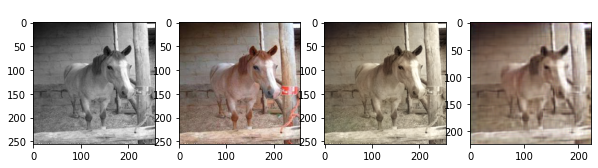

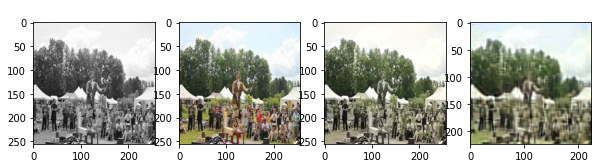

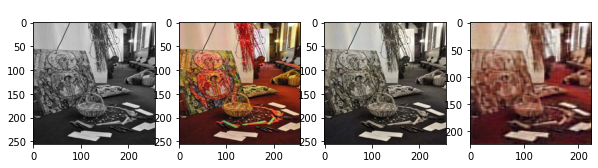

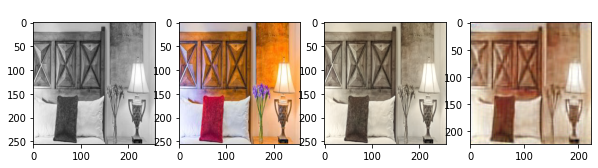

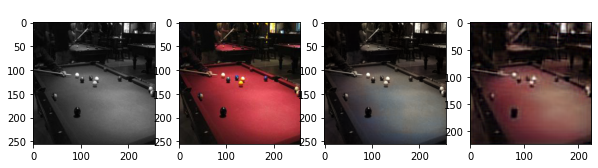

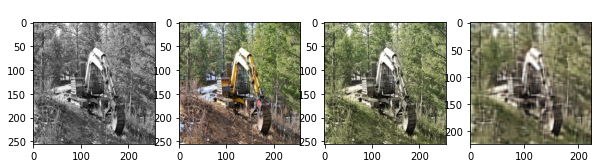

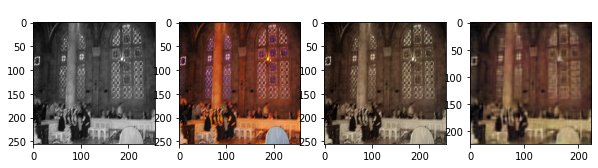

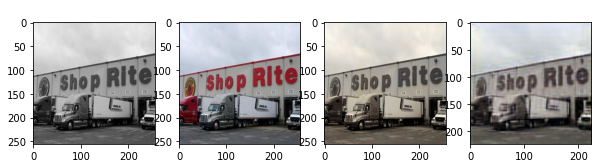

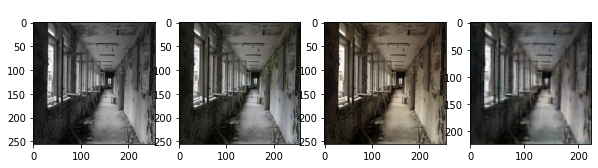

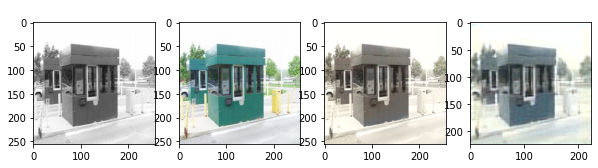

In [67]:
show = 2
for i in range((show-1)*10,10*show):
  show_results(i,"test")

In [ ]:
def colorize_custom_image(image_dir):

  img = Image.open(image_dir)
  gan_img = img.resize((224,224))
  gan_img_array = np.expand_dims(np.array(gan_img)axis=0)/255
  img_array = np.expand_dims(np.array(img),axis=0)/255
  gray_img = np.expand_dims(np.array(img.convert("L"),axis=0)/255
  gan_gray_img = np.array(gan_img.convert("L"))
  gan_gray_img = np.expand_dims(gray2rgb(gan_gray_img),axis=0)

  unet_predict = unet.predict(gray_img)
  gan_predict = generator.predict()




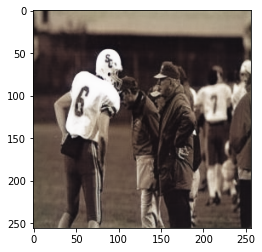

In [ ]:
plt.imshow(j[30])

In [ ]:
np.max(j[0])

0.9695016

In [ ]:
np.sum(X[0])

36713.19607843137